#  Decision Tree Model for Hypertension Prediction


In [1]:
# Necessary Libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random 
from pprint import pprint
from __future__ import division
%config IPCompleter.greedy=True

In [2]:
print(np.__version__)
print(pd.__version__)
print(sns.__version__)

1.15.4
0.23.4
0.9.0


## Data Preprocessing

In [3]:
# loading and viewing our dataset 
df = pd.read_csv("Nepal-Surhket.csv")
df.head()

,Sex,Agecat,Marrital,Edu4,Occupation4,Poor,Smoking,DoseSmoking,Tobacco,DoseTobacco,...,FamilyHxHT,BMI,BMIcat,WC,WClevel,SBP,DBP,HTN,ControledBP,WeightageAsianAG
0,2,4,1,1,2,0,2,0,2,0,...,2,18.261505,1,90.0,1,120.0,80.0,1,1,4.70
1,2,4,3,1,3,0,2,0,2,0,...,2,18.999417,2,86.0,0,110.0,62.0,0,1,4.70
2,2,4,1,1,2,1,3,0,2,0,...,2,22.232140,2,98.0,1,160.0,100.0,1,0,4.70
3,2,4,3,1,4,0,3,0,2,0,...,2,24.238227,2,99.0,1,128.0,65.0,0,1,4.70
4,2,4,2,1,2,0,3,0,2,0,...,2,19.977775,2,74.0,0,100.0,60.0,0,1,4.01


In [4]:
indexedData = df[['Sex','FamilyHxHT','Poor','BMI', 'WC', 'SBP', 'DBP', 'HTN']]
modifiedData = indexedData.dropna()
modifiedData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1159 entries, 0 to 1158
Data columns (total 8 columns):
Sex           1159 non-null int64
FamilyHxHT    1159 non-null int64
Poor          1159 non-null int64
BMI           1159 non-null float64
WC            1159 non-null float64
SBP           1159 non-null float64
DBP           1159 non-null float64
HTN           1159 non-null int64
dtypes: float64(4), int64(4)
memory usage: 81.5 KB


### Formating and Visualization

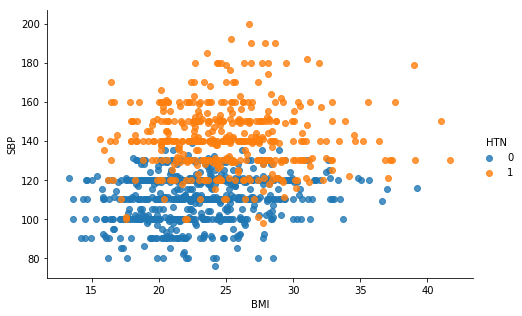

In [5]:
sns.lmplot(data = modifiedData, x = "BMI", y = "SBP", hue ='HTN',
            fit_reg = False, height = 4.5, aspect = 1.5)

### Train-Test-Split


In [6]:
# Function designed to split our data into testing and training sets 
def train_test_split(modifiedData, test_size): 
    
    indices = modifiedData.index.tolist()
    test_indices = random.sample(population = indices, k=test_size)

    test_df = modifiedData.loc[test_indices]
    train_df = modifiedData.drop(test_indices)
     
    return train_df, test_df


In [7]:
# create values for our testing and training sets with an 80-20 split 
train_df, test_df = train_test_split(modifiedData, test_size =232)
test_df.head()

,Sex,FamilyHxHT,Poor,BMI,WC,SBP,DBP,HTN
558,2,2,0,22.806017,59.0,123.0,80.0,0
450,1,2,0,19.379197,92.0,120.0,80.0,0
1033,1,2,0,15.776830,81.0,115.0,67.0,0
46,2,2,1,24.497545,92.0,150.0,83.0,1
345,2,1,0,29.234210,100.0,119.0,79.0,1


# Helper Functions


In [8]:
# we only want the labels from our training data 
data = train_df.values

### Data Purity

In [9]:
# Function to make sure data is "pure", meaning it only has 1 label
# When creating our tree algorithms, if subgroup of the data is pure, we can proceed with classification since only 1 value
# If data subgroup is not pure, we must contrinue classifying and spliting 
def check_purity(data):
    
    label_column = data[:,-1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False
    

In [10]:
# true if 1 label, false if >1 
check_purity(train_df[train_df.SBP > 140].values)

True

### Classify

In [11]:
# Classification function to classify each data groups based on parameters

def classify_data(data):
    # create 2 arrays, the unique label columns and a count of each label
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts = True)
    
    # gets the most occuring label from unique label
    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [12]:
# testing the fn, should return the label depending on parameters
classify_data(train_df[(train_df.SBP > 120) & (train_df.DBP < 140)].values)

1.0

### Potential Splits 

In [13]:
"""
Function to get the values between two data point to better split the data 
"""
def get_potential_splits(data): 
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns -1):
        potential_splits[column_index] = []
        values = data[:, column_index]
        unique_values = np.unique(values)
    
        for index in range(len(unique_values)):
            if index != 0:
                current_value = unique_values[index]
                prev_value = unique_values[index -1]
                potential_split = (current_value + prev_value) / 2
            
                potential_splits[column_index].append(potential_split)
        
    
    return potential_splits

In [14]:
potential_splits = get_potential_splits(train_df.values)

### Split Data 

In [15]:
"""
Function to split data columns into sub-groups, where the values are above or below the split value
"""
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]
    data_below = data[split_column_values < split_value]
    data_above = data[split_column_values >= split_value]
    
    
    return data_below, data_above

In [16]:
split_column = 3 
split_value = 140


In [17]:
data_below, data_above = split_data(data, split_column, split_value)


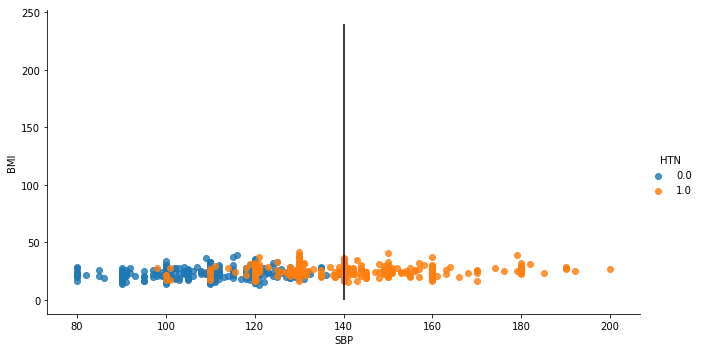

In [18]:
"""
Testing our functions with an example splitting our SBP values at 140
"""
plotting_df = pd.DataFrame(data, columns= modifiedData.columns)
sns.lmplot(data= plotting_df, x='SBP', y='BMI', hue = 'HTN', fit_reg = False,
          height = 5, aspect = 1.8,)

plt.vlines(x=split_value, ymin= 0, ymax = 240)
           

### Entropy

##### Decision trees involes parititioning data into subsets that contain similar values (homogenous)
#### -If sample is completely homogenous, the entropy is 0 
#### -If sample is equally divided, the entropy is 1 

#### Entropy in DT are used to draw boundaries in the data
#### -If a branch has entropy of 0, it is a leaf node(we can classify, no need to split)




In [19]:

def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [20]:
label_column = data[:, -1]
_, counts = np.unique(label_column, return_counts = True)

# We are evaluating our data and the counts of each label 
print(counts)
total_count = counts.sum()
print(total_count)
probability = counts / total_count
print(probability)
calculate_entropy(data_below)

[568 359]
927
[0.61272923 0.38727077]


0.963015673155051

In [21]:
"""
Calculating the overall entropy in our data
This should give us an indication of how well our data's values
"""
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [22]:
calculate_overall_entropy(data_below, data_above)

0.963015673155051

In [23]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [24]:
determine_best_split(data, potential_splits)

(6, 89.5)

### Decision Tree Algorithm

In [25]:
"""
In general, this decision tree will work as a recursive function to continually creating sub-tree's based on purity until
 all the values have been classified or 'labeled'
"""
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data prep
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # instantiate sub-tree
        feature_name = COLUMN_HEADERS[split_column]
        question = "{} <= {}".format(feature_name, split_value)
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [26]:
tree = decision_tree_algorithm(test_df, max_depth=6)
pprint(tree)

{'DBP <= 88.5': [{'SBP <= 136.5': [{'FamilyHxHT <= 1.5': [{'BMI <= 24.693217015': [0.0,
                                                                                   {'BMI <= 25.730880585': [1.0,
                                                                                                            0.0]}]},
                                                          0.0]},
                                   1.0]},
                 1.0]}


In [32]:
example = test_df.iloc[0]
example

Sex                            2
FamilyHxHT                     2
Poor                           0
BMI                       22.806
WC                            59
SBP                          123
DBP                           80
HTN                            0
classification                 0
classification_correct      True
Name: 558, dtype: object

In [28]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if example[feature_name] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [29]:
classify_example(example, tree)
print(tree)

{'DBP <= 88.5': [{'SBP <= 136.5': [{'FamilyHxHT <= 1.5': [{'BMI <= 24.693217015': [0.0, {'BMI <= 25.730880585': [1.0, 0.0]}]}, 0.0]}, 1.0]}, 1.0]}


In [30]:
def calculate_accuracy(df, tree):

    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["HTN"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

In [31]:
accuracy = calculate_accuracy(test_df, tree)
accuracy

0.9913793103448276